In [2]:
from googleapiclient.discovery import build
import pandas as pd
import seaborn as sns
import os
import googleapiclient.discovery
from googleapiclient.errors import HttpError
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

Retrieving unique YouTube channel ID's associated with specific channel usernames("loganpaulvlogs","penguinz0").

In [3]:
API_KEY = "" #This is a variable is used to stores YouTube Data API key. It's required to access the YouTube Data API, which provides programmatic access to YouTube data.

def get_channel_id_by_username(username): #This is a function that takes a YouTube channel username as input and returns the associated YouTube Channel ID.
    youtube = build("youtube", "v3", developerKey=API_KEY)
    response = youtube.search().list(
        part="snippet",
        q=username,
        type="channel",
        maxResults=1
    ).execute()
    if "items" in response and len(response["items"]) > 0:
        channel_id = response["items"][0]["snippet"]["channelId"]
        return channel_id
    return None

channel_username = ["loganpaulvlogs","penguinz0"] #Channel usernames

for i in range(0,2):
    try:
        channel_id = get_channel_id_by_username(channel_username[i])
        if channel_id:
            print(f"Channel ID for {channel_username[i]}: {channel_id}")
        else:
            print(f"Channel ID for {channel_username[i]} not found.")
    except Exception as e:
        print(f"Error: {e}")

Channel ID for loganpaulvlogs: UCG8rbF3g2AMX70yOd8vqIZg
Channel ID for penguinz0: UCq6VFHwMzcMXbuKyG7SQYIg


Retrieving comments from YouTube videos associated with specific YouTube channels and storing them in a DataFrame.

In [ ]:
def get_video_comments(video_id): #This function retrieves comments from a YouTube video specified by its video_id. 
    youtube = googleapiclient.discovery.build("youtube", "v3", developerKey=API_KEY)

    comments = []
    page_token = None

    while True:
        try:
            response = youtube.commentThreads().list(
                part="snippet",
                videoId=video_id,
                textFormat="plainText",
                pageToken=page_token,
                maxResults=100
            ).execute()

            for item in response["items"]:
                comment = item["snippet"]["topLevelComment"]["snippet"]["textDisplay"]
                comments.append(comment)

            if "nextPageToken" in response:
                page_token = response["nextPageToken"]
            else:
                break

        except HttpError as e:
            print(f"An HTTP error occurred: {e}")
            break

    return comments

def get_channel_comments(channel_id): #This function retrieves comments from all videos uploaded by a YouTube channel specified by its channel_id within the last 30 days.
    youtube = googleapiclient.discovery.build("youtube", "v3", developerKey=API_KEY)
    thirty_days_ago = (datetime.now() - timedelta(days=30)).strftime("%Y-%m-%dT%H:%M:%SZ")

    comments = []

    try:
        response = youtube.search().list(
            part="id",
            channelId=channel_id,
            maxResults=50,  
            publishedAfter=thirty_days_ago
        ).execute()

        video_ids = [item["id"]["videoId"] for item in response["items"]]

        for video_id in video_ids:
            video_comments = get_video_comments(video_id)
            comments.extend(video_comments)

    except HttpError as e:
        print(f"An HTTP error occurred: {e}")

    return comments

channel_ids = ["UCG8rbF3g2AMX70yOd8vqIZg", "UCq6VFHwMzcMXbuKyG7SQYIg"]

all_comments = []

for channel_id in channel_ids: #This loop creates a dictionary with key "Comments" and values are text data recieved through "get_channel_comments()" funtion.
    try:
        comments = get_channel_comments(channel_id)
        all_comments.extend(comments)

    except Exception as e:
        print(f"An error occurred for channel ID '{channel_id}': {e}")

df = pd.DataFrame({"Comments": all_comments}) #Creating pandas dataframe.

Data points recieved: 214047

In [213]:
df.shape

(214047, 1)

Saving the dataframe using "to_pickle" funtion.

In [31]:
df.to_pickle('C:/Users/Varun/Desktop/Project-1/DataFrame3(after VADER labeling ).pkl')

Use this to read any file in the folder

In [41]:
df = pd.read_pickle('DataFrame1.pkl') 

Data Preprocessing:

In [42]:
df

,Comments
0,Imagine how many times this sicko DIDNT get ca...
1,R Belly must fall
2,cupcake
3,The sequel to the cupcake story
4,Ugh I was not expecting this topic. My niece j...
...,...
214042,❤
214043,charlies streams make me want to eat pringles
214044,W
214045,Will we ever see beef testosterone again


In [217]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214047 entries, 0 to 214046
Data columns (total 1 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   Comments  214047 non-null  object
dtypes: object(1)
memory usage: 1.6+ MB


Importing NLTK library and initializing various text preprocessing tools from it.

In [4]:
import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import re

# Initializing stopwords, and lemmatizer
stop_words = stopwords.words('english')
lzr = WordNetLemmatizer()

"preprocess_text()" function takes raw text as input and performs a series of text cleaning and normalization steps to prepare the text for natural language processing (NLP) tasks. The result is a clean and standardized text that is easier to work with.

In [5]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    tokens = nltk.word_tokenize(text)

    tokens = [word for word in tokens if word not in stop_words]

    lemmatized_tokens = [lzr.lemmatize(token) for token in tokens]

    preprocessed_text = ' '.join(lemmatized_tokens)
    
    return preprocessed_text

In [29]:
# Appling preprocessing to each comment
preprocessed_comments = [preprocess_text(comment) for comment in df['Comments']]

Assigning the preprocessed comments back to the original dataframe.

In [30]:
df['Comments'] = preprocessed_comments

Sentiment analysis on a DataFrame (df) using the VADER (Valence Aware Dictionary and sEntiment Reasoner) sentiment analysis tool. VADER is specifically designed for sentiment analysis of text, especially social media content, and it provides a compound score that represents the overall sentiment of a piece of text. 
This step is to create labeled data for our machine learning model.

In [32]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

def get_sentiment_label(compound_score): #Applying basic logic on compound scores to create sentiment_label column.
    if compound_score >= 0.2:
        return 2
    elif compound_score <= -0.2:
        return 0
    else:
        return 1
        
df['sentiment_scores'] = df['Comments'].apply(lambda comment: analyzer.polarity_scores(comment))
df['compound_score'] = df['sentiment_scores'].apply(lambda score: score['compound'])
df['sentiment_label'] = df['compound_score'].apply(get_sentiment_label)

Checking if the data is balanced.

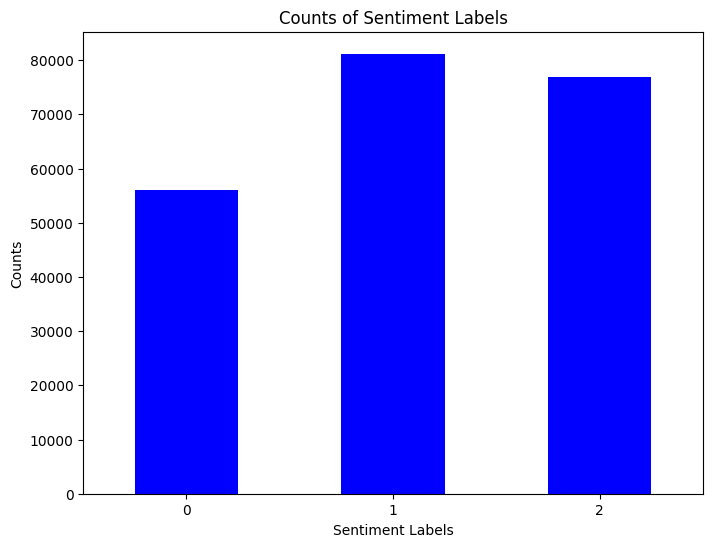

0    56014
1    81176
2    76857
Name: sentiment_label, dtype: int64


In [35]:
counts = df['sentiment_label'].value_counts().sort_index() # Counting the occurrences of 0s, 1s, and 2s in the "sentiment_label" column

# Creating a bar graph
plt.figure(figsize=(8, 6))
counts.plot(kind='bar', color='blue')
plt.title('Counts of Sentiment Labels')
plt.xlabel('Sentiment Labels')
plt.ylabel('Counts')
plt.xticks(rotation=0)
plt.show()

print(counts)

Clearly the number of positive and neutral comments are higher than the negative comments. So, data balancing is needed.
The following code balances the data by limiting the number of data points for each label to the average of number of positive, negative and neutral comments.

In [36]:
desired_samples = 68595 # assigning the desired sample size to the average of the negative and neutral.

balanced_df = pd.DataFrame(columns=['Comments', 'compound_score', 'sentiment_label']) # Initializing an empty DataFrame to store balanced data

# Iterating through each label and randomly select samples to meet the desired count
for label in df['sentiment_label'].unique():
    label_data = df[df['sentiment_label'] == label]
    
    if len(label_data) >= desired_samples:
        samples = label_data.sample(desired_samples, random_state=42)
    else:
        samples = label_data
    
    balanced_df = pd.concat([balanced_df, samples])

df = balanced_df

Dataset is fairly balanced now, as observed in the graph below.

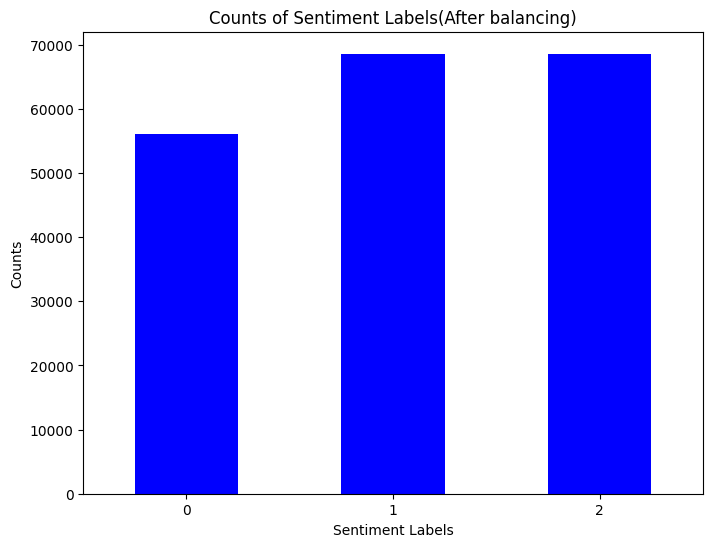

0    56014
1    68595
2    68595
Name: sentiment_label, dtype: int64


In [38]:
counts = df['sentiment_label'].value_counts().sort_index() # Counting the occurrences of 0s, 1s, and 2s in the "sentiment_label" column

# Creating a bar graph
plt.figure(figsize=(8, 6))
counts.plot(kind='bar', color='blue')
plt.title('Counts of Sentiment Labels(After balancing)')
plt.xlabel('Sentiment Labels')
plt.ylabel('Counts')
plt.xticks(rotation=0)
plt.show()

print(counts)

Finding the Vocabulary Size

In [54]:
vocab = tokenizer.word_index

vocab_size = len(vocab)
print(f"Vocabulary Size: {vocab_size}")

Vocabulary Size: 61452


"sentiment_scores" is dropped as it's irrelevent.

In [23]:
df.drop(columns="sentiment_scores",inplace=True)

Model Building:

In [11]:
# Importing all the necessary libraries
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.layers import Input, Embedding, LSTM, Dropout, Dense
from keras.models import Model
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, classification_report, f1_score

Creating input and output variables.

In [30]:
X_comments = df['Comments']
Y_compound = df['compound_score']
Y_sentiment_labels = df['sentiment_label']  

Tokenization and padding the comment sequences.

In [26]:
tokenizer = Tokenizer(num_words=45000, lower=True) #common practice to limit vocabulary size to reduce memory usage and improve model performance.
tokenizer.fit_on_texts(X_comments)
X_comments = tokenizer.texts_to_sequences(X_comments)
max_sequence_length = 100
X_comments = pad_sequences(X_comments, maxlen=max_sequence_length)

One-hot Encoding Y_sentiment_labels

In [245]:
num_classes = 3
Y_sentiment_labels_one_hot = to_categorical(Y_sentiment_labels, num_classes=num_classes)

Train, Test Split.

In [254]:
X_train, X_test, Y_compound_train, Y_compound_test, Y_sentiment_train, Y_sentiment_test = train_test_split(
    X_comments, Y_compound, Y_sentiment_labels_one_hot, test_size=0.2, random_state=42
)

Model Architecture:

In [255]:
# Input Layer
input_layer = Input(shape=(max_sequence_length,)) 

# Embedding layer
embedding_dim = 64
embedding_layer = Embedding(input_dim=vocab_size, output_dim=embedding_dim)(input_layer)

# LSTM layer
lstm_layer = LSTM(units=32, dropout=0.5, recurrent_dropout=0.3)(embedding_layer)

# Dense layer
dense_layer = Dense(units=16, activation='relu', kernel_regularizer=l2(0.001))(lstm_layer)

# Output layers
compound_output_layer = Dense(units=1, activation='linear', name='compound_output')(dense_layer)

sentiment_label_output_layer = Dense(units=num_classes, activation='softmax', name='sentiment_label_output')(dense_layer)

Model Compilation:

In [256]:
# Creating the model
model = Model(inputs=input_layer, outputs=[compound_output_layer, sentiment_label_output_layer])

# Compiling the model
model.compile(
    loss={'compound_output': 'mean_squared_error', 'sentiment_label_output': 'categorical_crossentropy'},
    optimizer=Adam(learning_rate=0.001),
    metrics={'compound_output': 'mae', 'sentiment_label_output': 'accuracy'}
)

Model Training:

In [257]:
# Training the model
history = model.fit(
    X_train,
    {'compound_output': Y_compound_train, 'sentiment_label_output': Y_sentiment_train},
    validation_data=(
        X_test,
        {'compound_output': Y_compound_test, 'sentiment_label_output': Y_sentiment_test}
    ),
    epochs=5,
    batch_size=42
)

Epoch 1/5
3681/3681 [==============================] - 212s 57ms/step - loss: 0.5088 - compound_output_loss: 0.0671 - sentiment_label_output_loss: 0.4297 - compound_output_mae: 0.1619 - sentiment_label_output_accuracy: 0.8324 - val_loss: 0.2799 - val_compound_output_loss: 0.0315 - val_sentiment_label_output_loss: 0.2394 - val_compound_output_mae: 0.1005 - val_sentiment_label_output_accuracy: 0.9090
Epoch 2/5
3681/3681 [==============================] - 208s 56ms/step - loss: 0.2255 - compound_output_loss: 0.0243 - sentiment_label_output_loss: 0.1923 - compound_output_mae: 0.0920 - sentiment_label_output_accuracy: 0.9265 - val_loss: 0.1724 - val_compound_output_loss: 0.0138 - val_sentiment_label_output_loss: 0.1502 - val_compound_output_mae: 0.0698 - val_sentiment_label_output_accuracy: 0.9464
Epoch 3/5
3681/3681 [==============================] - 209s 57ms/step - loss: 0.1499 - compound_output_loss: 0.0139 - sentiment_label_output_loss: 0.1280 - compound_output_mae: 0.0707 - sentiment_

Model Evaluation:

Visualizing the training and validation loss as well as training and validation accuracy during the training of a neural network model. 

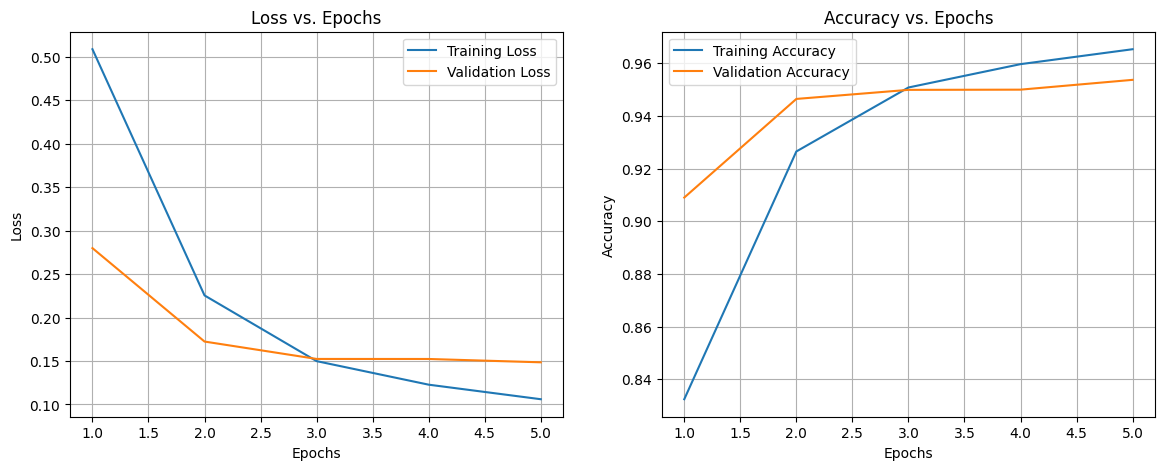

In [258]:
# Accessing the loss history from the training process
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['sentiment_label_output_accuracy']
val_accuracy = history.history['val_sentiment_label_output_accuracy']

# Creating subplots for loss and accuracy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Ploting the training and validation loss
ax1.plot(range(1, len(loss) + 1), loss, label='Training Loss')
ax1.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.set_title('Loss vs. Epochs')
ax1.legend()
ax1.grid(True)

# Ploting the training and validation accuracy
ax2.plot(range(1, len(accuracy) + 1), accuracy, label='Training Accuracy')
ax2.plot(range(1, len(val_accuracy) + 1), val_accuracy, label='Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.set_title('Accuracy vs. Epochs')
ax2.legend()
ax2.grid(True)

plt.show()

Printing performance parameters

In [259]:
# Evaluating the model on the test data
evaluation_metrics = model.evaluate(X_test, {'compound_output': Y_compound_test, 'sentiment_label_output': Y_sentiment_test})

# Printing the metrics
for name, value in zip(model.metrics_names, evaluation_metrics):
    print(f'{name}: {value:.4f}')

1208/1208 [==============================] - 6s 5ms/step - loss: 0.1485 - compound_output_loss: 0.0103 - sentiment_label_output_loss: 0.1327 - compound_output_mae: 0.0529 - sentiment_label_output_accuracy: 0.9537
loss: 0.1485
compound_output_loss: 0.0103
sentiment_label_output_loss: 0.1327
compound_output_mae: 0.0529
sentiment_label_output_accuracy: 0.9537


Evaluating the model's performance on a sentiment classification task, including the calculation of a confusion matrix, F1 score, and a classification report. 

1208/1208 [==============================] - 6s 5ms/step


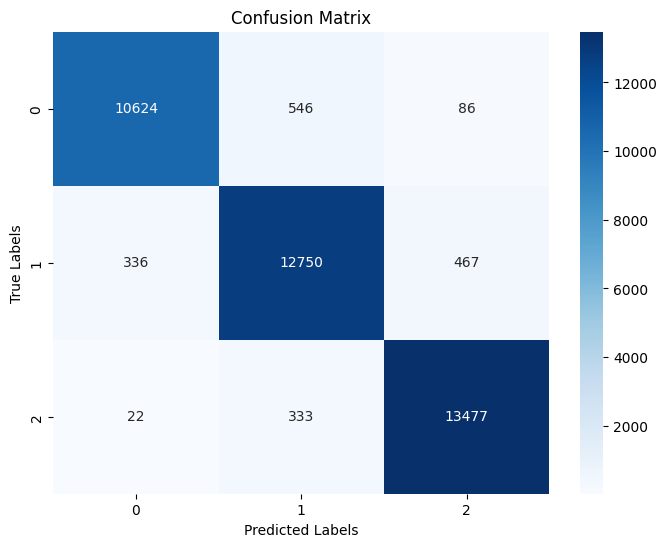

Weighted F1 Score: 0.9536626567400638

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.94      0.96     11256
           1       0.94      0.94      0.94     13553
           2       0.96      0.97      0.97     13832

    accuracy                           0.95     38641
   macro avg       0.95      0.95      0.95     38641
weighted avg       0.95      0.95      0.95     38641



In [260]:
y_compound_pred, y_sentiment_pred = model.predict(X_test)

y_sentiment_true = np.argmax(Y_sentiment_test, axis=1)
y_sentiment_pred = np.argmax(y_sentiment_pred, axis=1)

# Calculating confusion matrix for sentiment
cm = confusion_matrix(y_sentiment_true, y_sentiment_pred)

# Calculating F1 score for sentiment
f1 = f1_score(y_sentiment_true, y_sentiment_pred, average='weighted')

# Generating classification report for sentiment
report = classification_report(y_sentiment_true, y_sentiment_pred)

# Creating a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=True, yticklabels=True)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Printing F1 score and classification report
print("Weighted F1 Score:", f1)
print("\nClassification Report:\n", report)

Saving the model

In [262]:
import pickle
with open('LSTM_Model','wb') as f:
    pickle.dump(model,f)

How to use the model?
pip install all the libraries.
1. Run code #1: It imports all the necessary libraries and initializations.
2. Run code #2: Loads the trained model
3. Run code #3: defines get_sentiment funtion
4. Run code #4: initialize text_ variable with whatever text you want
5. Output: compound score is ranges from -1 to 1, -1 being the most negative and 1 being the most positive. Sentiment label ranges from 0 to 2, 0 = negative, 1 = neutral, 2 = positive

In [1]:
#1
import pickle
import pandas as pd
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, LancasterStemmer, SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
import re

X_comments = pd.read_pickle('X_comments.pkl') 

stop_words = stopwords.words('english')
porter_stemmer = PorterStemmer()
lancaster_stemmer = LancasterStemmer()
snowball_stemmer = SnowballStemmer(language = 'english')
lzr = WordNetLemmatizer()
max_sequence_length = 100
tokenizer = Tokenizer(num_words=45000, lower=True)
tokenizer.fit_on_texts(X_comments)
X_comments = tokenizer.texts_to_sequences(X_comments)
X_comments = pad_sequences(X_comments, maxlen=max_sequence_length)

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    tokens = nltk.word_tokenize(text)

    tokens = [word for word in tokens if word not in stop_words]

    lemmatized_tokens = [lzr.lemmatize(token) for token in tokens]

    preprocessed_text = ' '.join(lemmatized_tokens)
    
    return preprocessed_text

In [2]:
#2
with open('LSTM_Model', 'rb') as model_file:
    loaded_model = pickle.load(model_file)

Testing the model:

In [3]:
#3
def get_sentiment(text_comment):
    preprocessed_comment = preprocess_text(text_comment)  
    numeric_comment = tokenizer.texts_to_sequences([preprocessed_comment])
    numeric_comment = pad_sequences(numeric_comment, maxlen=max_sequence_length)

    predictions = loaded_model.predict(numeric_comment)

    sentiment_probabilities = predictions[1][0]

    highest_probability_index = sentiment_probabilities.argmax()

    compound_score = predictions[0][0]

    return compound_score, highest_probability_index

In [10]:
#4
text_ = "this is awesome"
comp_score, sentiment = get_sentiment(text_)
print("compound score = ", comp_score[0], "\nSentiment = ",sentiment)

1/1 [==============================] - 0s 41ms/step
compound score =  0.63860697 
Sentiment =  2
